In [92]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

from sklearn.preprocessing import QuantileTransformer, PowerTransformer, quantile_transform
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
np.random.SeedSequence(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [93]:
metadata = pd.read_csv('data/metadata.csv')
sup_metadata = pd.read_csv('data/supplemental_metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('data/val_labels.csv',index_col='sample_id')
targets = pd.read_csv('targets.csv',index_col='sample_id')
submission_format = pd.read_csv('data/submission_format.csv')

In [94]:
train_100 = pd.read_csv('train/train_100.csv', index_col=0,header=[0,1])
val_100 = pd.read_csv('train/val_100.csv', index_col=0,header=[0,1])
test_100 = pd.read_csv('test/test_100.csv', index_col=0,header=[0,1])

train_100.sort_index(axis=1,inplace=True)
val_100.sort_index(axis=1,inplace=True)
test_100.sort_index(axis=1,inplace=True)

In [95]:
train_set_100 = pd.concat([train_100,val_100],axis=0)
test_set_100 = pd.concat([val_100,test_100],axis=0)
train_set_100.shape, test_set_100.shape

((1059, 1600), (804, 1600))

In [96]:
train_50 = pd.read_csv('train/train_50.csv', index_col=0,header=[0,1])
val_50 = pd.read_csv('train/val_50.csv', index_col=0,header=[0,1])
test_50 = pd.read_csv('test/test_df_50.csv', index_col=0,header=[0,1])

train_50.sort_index(axis=1,inplace=True)
val_50.sort_index(axis=1,inplace=True)
test_50.sort_index(axis=1,inplace=True)
val_50.index = metadata[metadata.split == 'val'].index

In [97]:
train_set_50 = pd.concat([train_50,val_50],axis=0)
test_set_50 = pd.concat([val_50,test_50],axis=0)
train_set_50.shape, test_set_50.shape

((1059, 4200), (804, 4200))

In [98]:
train_200 = pd.read_csv('train/train_df_200.csv',index_col=0,header=[0,1])
val_200 = pd.read_csv('train/val_df_200.csv',index_col=0,header=[0,1])
test_200 = pd.read_csv('test/test_df_200.csv',index_col=0,header=[0,1])

test_200.sort_index(inplace=True,axis=1)
val_200.sort_index(inplace=True,axis=1)
train_200.sort_index(inplace=True,axis=1)

In [99]:
train_set_200 = pd.concat([train_200,val_200],axis=0)
test_set_200 = pd.concat([val_200,test_200],axis=0)
train_set_200.shape, test_set_200.shape

((1059, 1000), (804, 1000))

In [100]:
skf = StratifiedKFold(n_splits=5,random_state=RANDOM_SEED,shuffle=True)
log_loss_scorer = make_scorer(log_loss,needs_proba=True)

In [101]:
phy = 'phyllosilicate'
bas = 'basalt'
lr = LogisticRegression(solver='liblinear',C=10,random_state=RANDOM_SEED,penalty='l1')
lr

LogisticRegression(C=10, penalty='l1', random_state=777, solver='liblinear')

In [102]:
def get_coefs(X,y,c):
    lr = LogisticRegression(solver='liblinear',C=c,random_state=RANDOM_SEED,penalty='l1')
    print(cross_val_score(lr,X,y,cv=skf,scoring=log_loss_scorer).mean())
    lr.fit(X,y)
    # print(log_loss(y,lr.predict_proba(X)))
    coefs =  lr.coef_
    coefs_list  = []
    for id,wt in enumerate(tqdm(coefs[0])):
        if wt != 0:
            coefs_list.append(id)
    print(len(coefs_list))
    return coefs_list

In [103]:
def get_mz(mz,df):
    ''' returns list of columns for given mz'''
    cols_list = []
    for col in df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [104]:
def get_total_abundance(df):
    ''' returns total abundance for each sample'''
    tot_abund_df = pd.DataFrame(index=df.index)
    tot_abund_df['tot_abund'] = df.sum(axis=1)
    for mz in tqdm(range(0,100)):
        tot_abund_df[f"tot_abund_{mz}"] = df[get_mz(mz,df)].sum(axis=1)
    print(tot_abund_df.shape)
    return tot_abund_df

In [105]:
def get_grads(df,bin_size=5):
    ''' returns gradients for each mz'''
    grad_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        # df_mz_col1 = df_mz.iloc[:,0].values
        df_mz = df_mz.diff(axis=1)
        # df_mz.iloc[:,0] = df_mz_col1
        df_mz.dropna(axis='columns',inplace=True)
        # df_mz = df_mz/bin_size
        df_mz.columns = [col[0]+ '_' + col[1] + '_' + 'grad' for col in df_mz.columns]
        grad_df = pd.concat([grad_df,df_mz],axis=1)
    print(grad_df.shape)

    return  grad_df

In [106]:
def get_mean_std(df):
    ''' returns mean and std for each mz'''
    mean_std_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        df_mz[f'{mz}_mean'] = df_mz.mean(axis=1)
        df_mz[f'{mz}_std'] = df_mz.std(axis=1)
        mean_std_df = pd.concat([mean_std_df,df_mz],axis=1)
    print(mean_std_df.shape)
    return mean_std_df

In [107]:
# def add_fts(df):
#     tot_abund_df = get_total_abundance(df)
#     grad_df = get_grads(df)
#     mean_std_df = get_mean_std(df)
#     new_df = pd.concat([tot_abund_df,grad_df,mean_std_df],axis=1)
#     return new_df

In [108]:
cb_clf = CatBoostClassifier(verbose=999,random_seed=RANDOM_SEED)

In [109]:
train_set_100.shape, test_set_100.shape

((1059, 1600), (804, 1600))

In [110]:
assert (train_set_100.columns == test_set_100.columns).all()

In [111]:
t_100 = get_total_abundance(train_set_100)
g_100 = get_grads(train_set_100)
m_100 = get_mean_std(train_set_100)

 17%|█▋        | 17/100 [00:00<00:00, 163.36it/s]

(1059, 101)


 15%|█▌        | 15/100 [00:00<00:00, 141.89it/s]

(1059, 1500)


100%|██████████| 100/100 [00:01<00:00, 96.03it/s]

(1059, 1800)


In [112]:
t_100_test = get_total_abundance(test_set_100)
g_100_test = get_grads(test_set_100)
m_100_test = get_mean_std(test_set_100)


 16%|█▌        | 16/100 [00:00<00:00, 151.15it/s]

(804, 101)


 19%|█▉        | 19/100 [00:00<00:00, 181.48it/s]

(804, 1500)


100%|██████████| 100/100 [00:00<00:00, 134.75it/s]

(804, 1800)


In [113]:
t_100_test.sort_index(inplace=True,axis=1)
t_100.sort_index(inplace=True,axis=1)

m_100_test.sort_index(inplace=True,axis=1)
m_100.sort_index(inplace=True,axis=1)

g_100_test.sort_index(inplace=True,axis=1)
g_100.sort_index(inplace=True,axis=1)

In [114]:
assert (t_100.columns == t_100_test.columns).all()
assert (g_100.columns == g_100_test.columns).all()
assert (m_100.columns == m_100_test.columns).all()

In [115]:
ntrain = 1059
ntest = 804
NFOLDS = 5

In [116]:
oof_train_df = pd.DataFrame(index=metadata[metadata.split != 'test'].index, columns=['sample_id',*targets.columns])
oof_test_df = pd.DataFrame(index=metadata[metadata.split != 'train'].index, columns=['sample_id',*targets.columns])

In [120]:
agg_loss = []
for target in targets.columns:
    print('TARGET ',target)
    imp_fts = {}
    
    #  get all imp coefs for the target
    t_100_coefs = get_coefs(t_100,targets[target],1)
    g_100_coefs = get_coefs(g_100,targets[target],5)
    m_100_coefs = get_coefs(m_100,targets[target],10)
    o_100_coefs = get_coefs(train_set_100,targets[target],10)
    
    imp_fts['o_100_coefs'] = o_100_coefs
    imp_fts['t_100_coefs'] = t_100_coefs
    imp_fts['g_100_coefs'] = g_100_coefs
    imp_fts['m_100_coefs'] = m_100_coefs

    # get all imp_dfs and concat them
    train_imp_ = train_set_100.iloc[:,o_100_coefs]
    t_100_imp_ = t_100.iloc[:,t_100_coefs]
    g_100_imp_ = g_100.iloc[:,g_100_coefs]
    m_100_imp_ = m_100.iloc[:,m_100_coefs]

    print(train_imp_.shape,t_100_imp_.shape,g_100_imp_.shape,m_100_imp_.shape)
    X = pd.concat([train_imp_,t_100_imp_,g_100_imp_,m_100_imp_],axis=1)
    print(X.shape)

    # same goes for test set
    test_imp_ = test_set_100.iloc[:,o_100_coefs]
    t_100_imp_test = t_100_test.iloc[:,t_100_coefs]
    g_100_imp_test = g_100_test.iloc[:,g_100_coefs]
    m_100_imp_test = m_100_test.iloc[:,m_100_coefs]

    print(test_imp_.shape,t_100_imp_test.shape,g_100_imp_test.shape,m_100_imp_test.shape)
    
    X_test = pd.concat([test_imp_, t_100_imp_test, g_100_imp_test, m_100_imp_test],axis=1)
    print(X_test.shape)
    
    assert (X.columns == X_test.columns).all()

    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    Y = targets[target]

    cb_clf = CatBoostClassifier(verbose=False,random_seed=RANDOM_SEED)
    cv_loss = []
    for fold, (train_id, test_id) in enumerate(tqdm(skf.split(X,Y))):

        #  ohh man unwanted semi colon in iloc throws an error...
        X_train, Y_train = X.iloc[train_id,], Y.iloc[train_id,]
        X_val, Y_val = X.iloc[test_id,], Y.iloc[test_id,]

        # upsampling works??
        upsampler = SMOTETomek(random_state=RANDOM_SEED)
        X_res, Y_res = upsampler.fit_resample(X_train, Y_train) 
        print(X_res.shape,Y_res.shape)
        
        assert (X_res.columns == X_val.columns).all
        
        # train model  and pred on oof folds
        # cb_clf.fit(X_res.values,Y_res)
        
        calib = CalibratedClassifierCV(cb_clf, cv = skf, ensemble=True, method='sigmoid')
        calib.fit(X_res.values,Y_res)
        y_preds = calib.predict_proba(X_val.values)[:,1]
        fold_loss = log_loss(Y_val,y_preds)
        print(f'fold Loss {fold}: ',fold_loss)
        cv_loss.append(fold_loss)

        oof_train[test_id] = y_preds
        oof_test_skf[fold,:] = calib.predict_proba(X_test.values)[:,1]

    print('Training Loss:', log_loss(Y,calib.predict_proba(X.values)[:,1]))
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    oof_test_df[target] = oof_test
    oof_train_df[target] = oof_train

    print(f'Loss for {target}:')
    print(np.array(cv_loss).mean(),np.array(cv_loss).std())
    agg_loss.append(np.array(cv_loss).mean())
    print("---------------------------------------------------------------------------------------------")

print('AGG Loss:',np.array(agg_loss))
print('AGG Loss mean:',np.array(agg_loss).mean())

TARGET  basalt


100%|██████████| 101/101 [00:00<00:00, 101200.36it/s]

0.3122080659673273
11


0.2875808538517409


100%|██████████| 1500/1500 [00:00<00:00, 500912.10it/s]


54
0.26469583059665797


100%|██████████| 1800/1800 [00:00<00:00, 1801848.97it/s]


64
0.26355293461316703


100%|██████████| 1600/1600 [00:00<00:00, 1048412.19it/s]
0it [00:00, ?it/s]

61
(1059, 61) (1059, 11) (1059, 54) (1059, 64)
(1059, 190)
(804, 61) (804, 11) (804, 54) (804, 64)
(804, 190)
(1496, 190) (1496,)


1it [02:57, 177.50s/it]y specified. Specify more than one logger at same time is not thread safe.

fold Loss 0:  0.15681486358676086
(1494, 190) (1494,)


2it [06:05, 183.65s/it]

fold Loss 1:  0.13855843520941272
(1496, 190) (1496,)


3it [09:40, 197.89s/it]

fold Loss 2:  0.14822919993896153
(1500, 190) (1500,)


4it [12:12, 179.72s/it]

fold Loss 3:  0.16983939267469916
(1498, 190) (1498,)


5it [14:40, 176.01s/it]

fold Loss 4:  0.19615896983644807
Training Loss: 0.048393792559217864
Loss for basalt:
0.16192017224925648 0.0199714144177264
---------------------------------------------------------------------------------------------
TARGET  carbonate



100%|██████████| 101/101 [00:00<?, ?it/s]

0.30894076809741444
14



100%|██████████| 1500/1500 [00:00<00:00, 1556520.53it/s]

0.2409436946085326
47


0.19485118218983005


100%|██████████| 1800/1800 [00:00<?, ?it/s]


65


100%|██████████| 1600/1600 [00:00<?, ?it/s]
0it [00:00, ?it/s]

0.2431113108745886
62
(1059, 62) (1059, 14) (1059, 47) (1059, 65)
(1059, 188)
(804, 62) (804, 14) (804, 47) (804, 65)
(804, 188)
(1480, 188) (1480,)


1it [02:23, 143.69s/it]

fold Loss 0:  0.1430761335975491
(1482, 188) (1482,)


2it [04:50, 145.41s/it]

fold Loss 1:  0.044754843347378746
(1478, 188) (1478,)


3it [07:11, 143.61s/it]

fold Loss 2:  0.07410312957723897
(1476, 188) (1476,)


3it [08:54, 178.00s/it]


KeyboardInterrupt: 

In [31]:
# print(np.array(agg_loss).mean())
# the best so far..

0.1388152705879633


In [28]:
for col in t_100_imp_.columns:
    print(list(zip([col in t_100_imp_.columns],[col in t_100_imp_test.columns])))

[(True, True)]
[(True, True)]
[(True, True)]
[(True, True)]
[(True, True)]
[(True, True)]


In [29]:
test_preds = oof_test_df.iloc[:293]
train_preds = oof_train_df.iloc[766:]

In [30]:
agg_loss_train = []
for tar in targets.columns:
    loss = log_loss(val_labels[tar],train_preds[tar])
    print(tar, loss)
    agg_loss_train.append(loss)
print(np.array(agg_loss_train).mean())

basalt 0.15850320332367066
carbonate 0.09332460244726241
chloride 0.18157902904645437
iron_oxide 0.2540283403003364
oxalate 0.004332506637375774
oxychlorine 0.12818873652258664
phyllosilicate 0.22382875563753332
silicate 0.16677803088033832
sulfate 0.18498906558018913
sulfide 0.08360446543576545
0.14791567358115126


In [75]:
agg_loss

[0.14226846302558055,
 0.08027272411906984,
 0.15752241152198587,
 0.1988126749627003,
 0.0052526272088060984,
 0.14273793320294706,
 0.22813335661438144,
 0.18445175148899454,
 0.17714363067361621,
 0.06253218287016708]

In [31]:
agg_loss_test = []
for tar in targets.columns:
    loss = log_loss(val_labels[tar],test_preds[tar])
    print(tar, loss)
    agg_loss_test.append(loss)
print(np.array(agg_loss_test).mean())

basalt 0.033434242979313335
carbonate 0.019488846784173786
chloride 0.03886726293491854
iron_oxide 0.06642316153491316
oxalate 0.0015939970343837866
oxychlorine 0.03143309513315042
phyllosilicate 0.07371376921051923
silicate 0.04335263175031061
sulfate 0.037818961644436516
sulfide 0.010561948540603624
0.035668791754672295


In [34]:
oof_test_df.sample_id = metadata[metadata.split != 'train'].sample_id
oof_train_df.sample_id = metadata[metadata.split != 'test'].sample_id

In [35]:
oof_train_df.to_csv('screw_everything_oof_train_100_upsampled.csv', index=False)
oof_test_df.to_csv('screw_everthing_oof_test_100_upsampled.csv', index=False)

In [ ]:
# but why did phy imp fts are selected 235? had to investigate this...

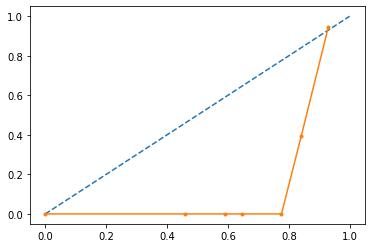

In [ ]:
# lr.fit(train_set_100,targets[phy])
# probs = lr.decision_function(train_set_100_new.iloc[:,:])
# prob_true, prob_pred = calibration_curve(targets_new[phy], probs, n_bins=10, normalize=True)
# plt.plot([0, 1], [0, 1], linestyle='--')
# # plot model reliability
# plt.plot(prob_pred, prob_true, marker='.')
# plt.show()

In [39]:
oof_train_df.shape

(1059, 11)

In [42]:
oof_train_df = pd.read_csv('screw_everything_oof_train_100_v2.csv')
oof_test_df = pd.read_csv('screw_everthing_oof_test_100_v2.csv')
oof_test_df.shape, oof_train_df.shape

((804, 11), (1059, 11))

In [15]:
lin_calib = LinearRegression()

In [119]:
rf_calib = RandomForestClassifier(random_state=RANDOM_SEED)

In [16]:
svc_calib = SVC(random_state=RANDOM_SEED,probability=True)
lin_svc_calib = LinearSVC(random_state=RANDOM_SEED)

In [45]:
from sklearn.isotonic import IsotonicRegression

In [53]:
y_min = x.min().min()
y_max = x.max().max()

In [54]:
is_calib = IsotonicRegression(y_min=y_min,y_max=y_max)
is_calib

IsotonicRegression(y_max=0.9978285726279558, y_min=3.408952723903238e-05)

In [43]:
x = oof_train_df.drop(['sample_id'],axis=1)

In [90]:
lr_calib = LogisticRegression(C=4,random_state=RANDOM_SEED,penalty='l1',solver='saga')

In [91]:
calib_loss = []
for tar in targets.columns:
    print('target:',tar)
    # calib_cv = cross_val_score(lin_svc_calib,x.values,targets[tar],cv=skf,scoring=log_loss_scorer)
    for i, (train_id,test_id) in enumerate(skf.split(x,targets[tar])):

        x_train,y_train = x.iloc[train_id,],targets[tar].iloc[train_id,]
        x_test,y_test = x.iloc[test_id,],targets[tar].iloc[test_id,]

        lr_calib.fit(x_train[tar].values.reshape(-1,1), y_train)
        preds = lr_calib.predict_proba(x_test[tar].values.reshape(-1,1))[:,1]
        print(preds.max(),preds.min())
        loss = log_loss(y_test,preds)

        print(f'fold {i}:',loss)
        # print(calib_cv) 
        # print(calib_cv.mean()), print(calib_cv.std())
        # calib_loss.append(calib_cv.mean())
        calib_loss.append(loss)
    print("-------------------------------------------------------------------")
print("Mean Loss: ", np.array(calib_loss).mean())

target: basalt
0.9999828520544426 0.02114548982864172
fold 0: 0.14072718294591102
0.9998664387171234 0.022454326311903493
fold 1: 0.12635244644442
0.9998696772071775 0.023572208084850853
fold 2: 0.10702074904856065
0.9999441697088574 0.02021789700828471
fold 3: 0.156516292778331
0.99998881939039 0.017128288026350774
fold 4: 0.19689498934395558
-------------------------------------------------------------------
target: carbonate
0.9977006058336212 0.012896762989639468
fold 0: 0.14272564160992218
0.9988103853111471 0.01725344261441168
fold 1: 0.06655104097085772
0.9972868226473764 0.0176284038125442
fold 2: 0.06317505796662609
0.9998764106440604 0.011239260626203704
fold 3: 0.180471081275038
0.9971887570618849 0.018009531573981434
fold 4: 0.053674950578297985
-------------------------------------------------------------------
target: chloride
0.9976723950590198 0.01708136558543241
fold 0: 0.2172898419856478
0.99759982866182 0.024894696725200154
fold 1: 0.11302583210357847
0.9926102734001

In [68]:
calib_loss = []
for tar in targets.columns:
    print('target:',tar)
    # calib_cv = cross_val_score(lin_svc_calib,x.values,targets[tar],cv=skf,scoring=log_loss_scorer)
    for i, (train_id,test_id) in enumerate(skf.split(x,targets[tar])):

        x_train,y_train = x.iloc[train_id,],targets[tar].iloc[train_id,]
        x_test,y_test = x.iloc[test_id,],targets[tar].iloc[test_id,]

        is_calib.fit(x_train[tar].values.reshape(-1,1), y_train)
        preds = is_calib.predict(x_test[tar].values.reshape(-1,1))
        print(preds.max(),preds.min())
        loss = log_loss(y_test,preds)

        print(f'fold {i}:',loss)
        # print(calib_cv) 
        # print(calib_cv.mean()), print(calib_cv.std())
        # calib_loss.append(calib_cv.mean())
        calib_loss.append(loss)
    print("---------------------------------------------------------------------------------------------")
print("Mean Loss: ", np.array(calib_loss).mean())

target: basalt
0.9978285726279558 3.408952723903238e-05
fold 0: 0.14834303819127134
0.9978285726279558 3.408952723903238e-05
fold 1: 0.11315003531499568
nan nan


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
cross_val_score(is_calib,x[bas].values,targets[bas],cv=skf,scoring=log_loss_scorer)

array([nan, nan, nan, nan, nan])

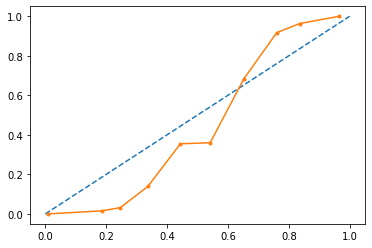

In [39]:
lr.fit(x,targets[phy])
probs = lr.decision_function(x)
prob_true, prob_pred = calibration_curve(targets[phy], probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(prob_pred, prob_true, marker='.')
plt.show()

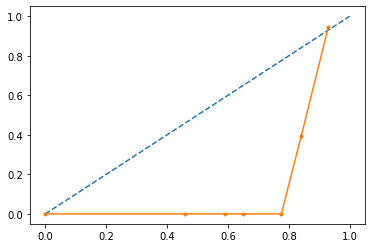

In [40]:
lr.fit(train_set_100,targets[phy])
probs = lr.decision_function(train_set_100)
prob_true, prob_pred = calibration_curve(targets[phy], probs, n_bins=10, normalize=True)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.plot(prob_pred, prob_true, marker='.')
plt.show()